# 实验三：参数估计 & 非参数估计

## 实验要求
### 截止日期：11月3日
作业的提交格式参考之前的说明，提交到18329300691@163.com
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$


<img src="https://i.loli.net/2021/03/31/7WT8naYPQc9N56x.png" alt="image.png" style="zoom: 40%;" /> 
<img src="https://i.loli.net/2021/03/31/qsetFODzM7IhYaN.png" alt="image.png" style="zoom:40%;" />

在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。


### 中级要求
在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计结果

# 一、基本要求
## 1. 生成数据集合

In [3]:
import numpy as np

# 设置参数
N = 1000
mu = np.array([[1, 4], [4, 1], [8, 4]])
cov_matrix = np.array([[[2, 0], [0, 2]], [[2, 0], [0, 2]], [[2, 0], [0, 2]]])
prior_probs_x1 = np.array([1/3, 1/3, 1/3])
prior_probs_x2 = np.array([0.6, 0.3, 0.1])

# 生成数据集合 X_1
X_1 = np.zeros((N, 3))
for i in range(N):
    # 生成数据点的分布模型
    model = np.random.choice(3, p=prior_probs_x1)
    # 生成二维随机向量
    x = np.random.multivariate_normal(mu[model], cov_matrix[model])
    X_1[i, :2] = x
    X_1[i, 2] = model

# 生成数据集合 X_2
X_2 = np.zeros((N, 3))
for i in range(N):
    # 生成数据点的分布模型
    model = np.random.choice(3, p=prior_probs_x2)
    # 生成二维随机向量
    x = np.random.multivariate_normal(mu[model], cov_matrix[model])
    X_2[i, :2] = x
    X_2[i, 2] = model

X_1


array([[ 7.59524085, -0.91207849,  1.        ],
       [ 8.43496884,  1.61723043,  2.        ],
       [ 3.49708543,  2.46913544,  1.        ],
       ...,
       [ 1.91989167,  3.45820823,  0.        ],
       [ 4.87118783,  3.71527834,  1.        ],
       [10.90678578,  2.35111318,  2.        ]])

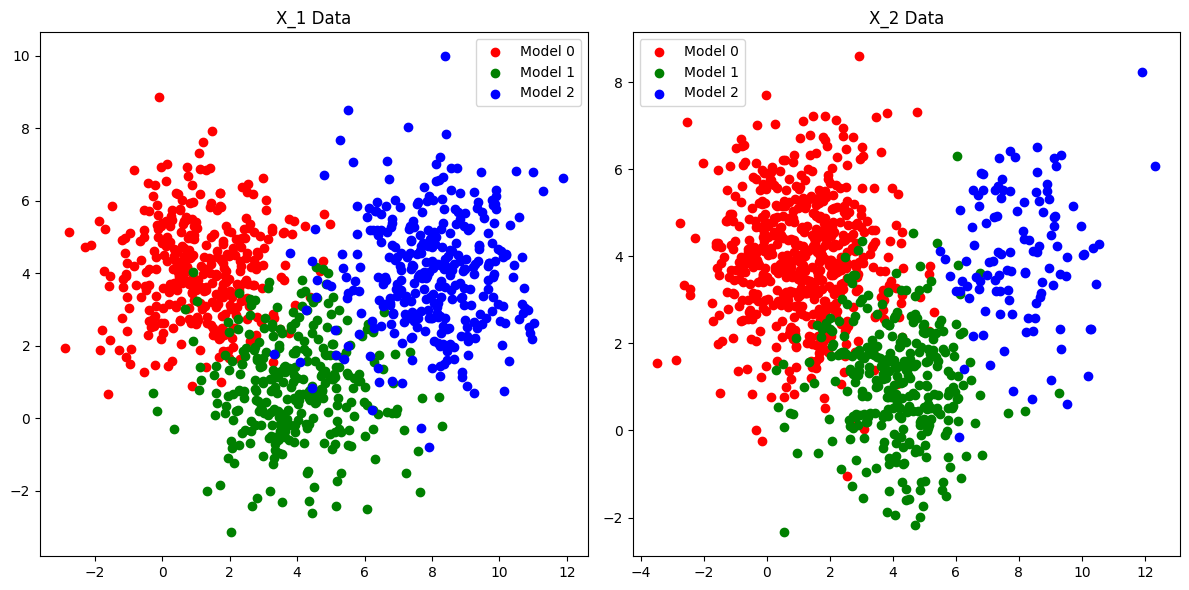

In [4]:
import matplotlib.pyplot as plt

# 提取X_1和X_2中的数据和标签
X_1_data = X_1[:, :2]
X_1_labels = X_1[:, 2]
X_2_data = X_2[:, :2]
X_2_labels = X_2[:, 2]

# 创建两个子图，分别表示X_1和X_2
plt.figure(figsize=(12, 6))

# 绘制X_1数据集
plt.subplot(1, 2, 1)
plt.scatter(X_1_data[X_1_labels == 0][:, 0], X_1_data[X_1_labels == 0][:, 1], c='r', label='Model 0')
plt.scatter(X_1_data[X_1_labels == 1][:, 0], X_1_data[X_1_labels == 1][:, 1], c='g', label='Model 1')
plt.scatter(X_1_data[X_1_labels == 2][:, 0], X_1_data[X_1_labels == 2][:, 1], c='b', label='Model 2')
plt.title('X_1 Data')
plt.legend()

# 绘制X_2数据集
plt.subplot(1, 2, 2)
plt.scatter(X_2_data[X_2_labels == 0][:, 0], X_2_data[X_2_labels == 0][:, 1], c='r', label='Model 0')
plt.scatter(X_2_data[X_2_labels == 1][:, 0], X_2_data[X_2_labels == 1][:, 1], c='g', label='Model 1')
plt.scatter(X_2_data[X_2_labels == 2][:, 0], X_2_data[X_2_labels == 2][:, 1], c='b', label='Model 2')
plt.title('X_2 Data')
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()


## 2. 最大似然估计

In [5]:
# 定义似然率函数
def likelihood(x, mu, cov):
    det = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.dot(np.dot((x - mu).T, inv_cov), (x - mu))
    return 1 / (2 * np.pi * np.sqrt(det)) * np.exp(exponent)

# 初始化错误计数
error_count_x1 = 0
error_count_x2 = 0

# 遍历X_1数据集
for i in range(N):
    x = X_1_data[i]
    true_label = int(X_1_labels[i])

    # 计算每个模型的似然率
    likelihoods = [likelihood(x, mu[j], cov_matrix[j]) for j in range(3)]

    # 使用似然率测试规则进行分类
    predicted_label = np.argmax(likelihoods)

    # 检查是否分类错误
    if predicted_label != true_label:
        error_count_x1 += 1

# 遍历X_2数据集
for i in range(N):
    x = X_2_data[i]
    true_label = int(X_2_labels[i])

    # 计算每个模型的似然率
    likelihoods = [likelihood(x, mu[j], cov_matrix[j]) for j in range(3)]

    # 使用似然率测试规则进行分类
    predicted_label = np.argmax(likelihoods)

    # 检查是否分类错误
    if predicted_label != true_label:
        error_count_x2 += 1

# 计算错误率
error_rate_x1 = error_count_x1 / N
error_rate_x2 = error_count_x2 / N

print("Error rate for X_1:", error_rate_x1)
print("Error rate for X_2:", error_rate_x2)


Error rate for X_1: 0.074
Error rate for X_2: 0.083


## 3. 最大后验概率估计

In [6]:
# 初始化错误计数
error_count_x1 = 0
error_count_x2 = 0

# 遍历X_1数据集
for i in range(N):
    x = X_1_data[i]
    true_label = int(X_1_labels[i])

    # 计算每个模型的后验概率
    posteriors = [likelihood(x, mu[j], cov_matrix[j]) * prior_probs_x1[j] for j in range(3)]

    # 使用MAP规则进行分类
    predicted_label = np.argmax(posteriors)

    # 检查是否分类错误
    if predicted_label != true_label:
        error_count_x1 += 1

# 遍历X_2数据集
for i in range(N):
    x = X_2_data[i]
    true_label = int(X_2_labels[i])

    # 计算每个模型的后验概率
    posteriors = [likelihood(x, mu[j], cov_matrix[j]) * prior_probs_x2[j] for j in range(3)]

    # 使用MAP规则进行分类
    predicted_label = np.argmax(posteriors)

    # 检查是否分类错误
    if predicted_label != true_label:
        error_count_x2 += 1

# 计算错误率
error_rate_x1 = error_count_x1 / N
error_rate_x2 = error_count_x2 / N

print("Error rate for X_1 (MAP rule):", error_rate_x1)
print("Error rate for X_2 (MAP rule):", error_rate_x2)


Error rate for X_1 (MAP rule): 0.074
Error rate for X_2 (MAP rule): 0.084


# 2、中级要求
## 高斯核函数估计

In [7]:
# 高斯核概率密度函数计算
def Gaussian_Kernel(x, X, h=2):
    # 计算概率p(x|w)
    p = (1 / (np.sqrt(2 * np.pi) * h)) * np.array([np.exp(-0.5 * np.dot(x - X[i], x - X[i]) / (h**2)) for i in range(len(X))]).mean()
    return p

In [10]:
# 高斯核函数估计方法 + 似然率测试规则
def Gaussian_Likelihood_cross(X, P, h):
    class_num = X.shape[1]  # 类别数，这里假设每个类别的数据都存储在X中
    num = X.shape[0]  # 数据集中的样本数量
    
    wrong = 0  # 初始化错误分类的计数器
    
    for i in range(num):
        class_p = np.zeros(class_num)  # 用于存储每个类别的概率
        
        for j in range(class_num):
            # 选择同一类别的数据
            data = X[X[:, 2] == j][:, :2]
            
            # 计算当前样本属于第j类别的概率
            class_p[j] = np.mean(Gaussian_Kernel(X[i, :2], data, h))
        
        # 找到具有最大概率的类别
        start_class = np.argmax(class_p)
        
        # 检查分类是否正确
        if start_class != X[i, 2]:
            wrong += 1
    
    # 计算并返回错误分类的比率
    return round(wrong / num, 3)


[0.017, 0.08, 0.079, 0.081, 0.078]


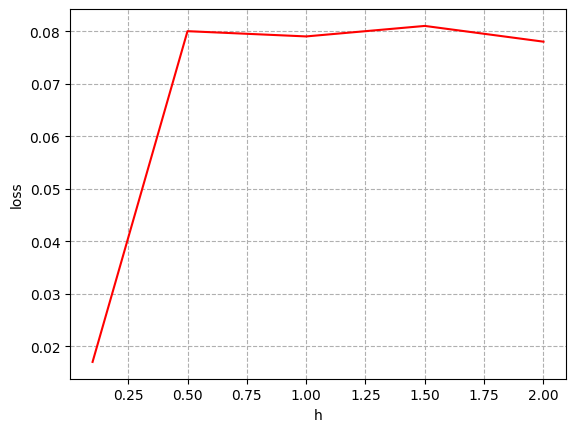

In [11]:
error_h = [] 
h_total = [0.1, 0.5, 1, 1.5, 2]
for h in h_total:
    error_h.append(Gaussian_Likelihood_cross(X_2, prior_probs_x2, h))

print(error_h)

plt.figure()
plt.plot(h_total, error_h, 'r')
plt.grid(linestyle="--")
plt.xlabel("h")
plt.ylabel("loss")
plt.show()


如果 h 值较小，高斯核会变得更加尖锐，对局部数据的影响更强烈。这可能导致模型对噪声敏感，因此可能会出现过拟合的情况。此时，分类错误率可能会升高，尤其是在数据具有一定程度的噪声时。

如果 h 值较大，高斯核会变得更加平滑，对整体数据的影响更均匀。这可以减少模型的复杂性，但可能会导致欠拟合，因为模型可能无法捕捉数据中的细节。此时，分类错误率可能会升高。

就本次实验而言，由于数据是根据固定分布生成，数据中噪声含量很少，因此、在h值较小时错误率反而偏低。而当h值增大时，反而无法很好的拟合数据集。

# 高级要求
## k-近邻概率密度估计

In [16]:
import math

def Kneibor_Eval(X, k):
    num = len(X)
    # Xtrain = np.array(X)
    # 生成200*200=40000个采样点，每个采样点对应三类的不同概率
    p = np.zeros((200, 200, 3))
    # 在[-5,15]的范围内，以0.1为步长估计概率密度
    for i in np.arange(0, 200):
        for j in np.arange(0, 200):
            total = []
            x = -5 + 0.1 * i
            y = -5 + 0.1 * j
            for data in X:
                # 生成标准差距离
                temp = []
                temp = list(data)
                dis = math.sqrt((x - data[0]) ** 2 + (y - data[1]) ** 2)
                temp.append(dis)
                total.append(temp)
            total = np.array(total)
             # 按最后一列排序
            total_sort = total[np.lexsort(total.T)]
            
            # 根据第k个数据点的位置计算S
            total_choose = total_sort[:k, :]
            S = math.pi * (total_choose[k - 1][3]**2)
            
            # 找到前k个数据点的类别,分别加到对应类的权重上
            num1 = sum(total_choose[:,2]==0.)
            num2 = sum(total_choose[:,2]==1.)
            num3 = sum(total_choose[:,2]==2.)
            
            # 计算每个采样点的概率密度函数
            res = []
            res.append(num1 / (S * 1200))
            res.append(num2 / (S * 1200))
            res.append(num3 / (S * 1200))
            p[i][j]=res
    return p

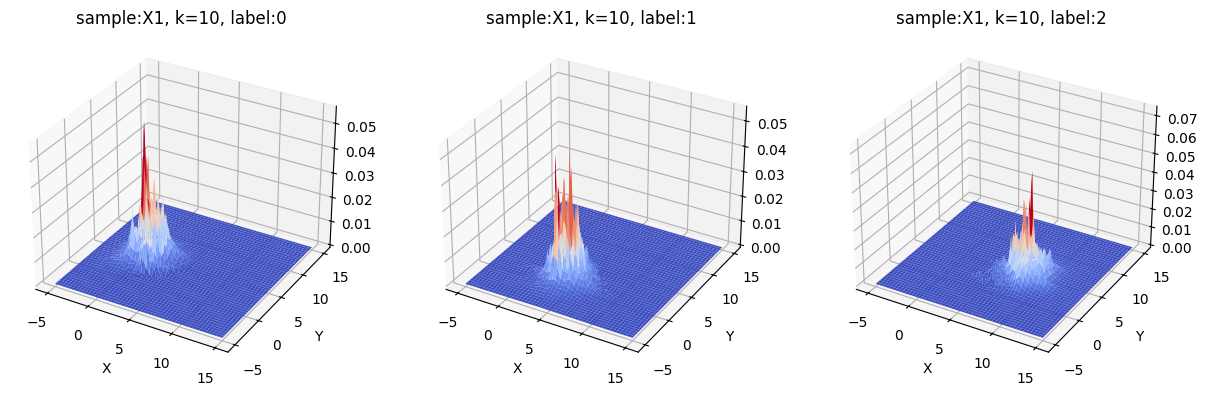

In [17]:
p = Kneibor_Eval(X_1, 10)  # 获得概率密度估计

X,Y = np.mgrid[-5:15:200j, -5:15:200j]
Z0 = p[:, :, 0]
Z1 = p[:, :, 1]
Z2 = p[:, :, 2]
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1,projection='3d')
ax.plot_surface(X, Y, Z0,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:0")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 2,projection='3d')
ax.plot_surface(X, Y, Z1,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:1")
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = plt.subplot(1, 3, 3,projection='3d')
ax.plot_surface(X, Y, Z2,cmap=plt.cm.coolwarm)
ax.set_title("sample:X1, k=10, label:2")
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

## 参数估计—Eager Learning
当我们已知**样本的概率密度分布**，需要对**解析表达式的参数**进行求解时，就可以采用参数估计方法。

先验概率：指根据以往经验和分析，在实验或采样前就可以得到的概率。
后验概率：指某件事已经发生，想要计算这件事发生的原因是由某个因素引起的概率。

<img src="https://s2.loli.net/2022/10/20/RmU1sV8CBtjrDli.png" alt="image.png" style="zoom:50%"/>

### 最大似然估计 (MLE)

* 给定随机样本 $\mathbf{X}=\left\{ \mathbf{x}_1,\mathbf{x}_2,...,\mathbf{x}_N \right\} =\left\{ \mathbf{x}_k \right\} _{k=1}^{N}$来自概率密度 $p\left( \mathbf{x}\mid \theta \right)$ 
* 假设样本是独立同分布的,则它们的联合概率分布为 $p\left( \mathbf{X}\mid \theta \right) =p\left( \mathbf{x}_1,\mathbf{x}_2,...,\mathbf{x}_N\mid \theta \right) =\prod_{k=1}^N{p}\left( \mathbf{x}_k\mid \theta \right)$
* 估计使似然函数取最大值的参数 $\hat{\theta}:\hat{\theta}=\underset{\theta}{\text{arg}\max}\prod_{k=1}^N{p}\left( \mathbf{x}_k\mid \theta \right)$ 
* 令似然函数对$\theta$的偏导数为零,求解 $\hat{\theta}:\frac{\partial}{\partial \theta}\log \prod_{k=1}^N{p}\left( \mathbf{x}_k\mid \theta \right) =0$
* 定义对数似然函数：  $L(\theta)=\log \prod_{k=1}^{N} p\left(\mathbf{x}_{k} \mid \theta\right) $
* 令似然函数对  $\theta$  的偏导数为零: 
$$
\begin{array}{l}
0&=\frac{\partial}{\partial \theta} L(\theta) \\
&=\frac{\partial}{\partial \theta} \log \prod_{k=1}^{N} p\left(\mathbf{x}_{k} \mid \theta\right) \\
&=\sum_{k=1}^{N} \frac{\partial}{\partial \theta} \log p\left(\mathbf{x}_{k} \mid \theta\right) \\
&=\sum_{k=1}^{N} \frac{1}{p\left(\mathbf{x}_{k} \mid \theta\right)} \frac{\partial}{\partial \theta} p\left(\mathbf{x}_{k} \mid \theta\right)
\end{array}
$$
* 求得  $\hat{\theta}$ , 对于样本点进行预测  $y=p(x \mid \hat{\theta})$ 

![Alt text](1697698114225.png)



### 最大后验概率估计 (MAP)
<img src="https://s2.loli.net/2022/10/20/LqxEFgKtNwl9ZG5.png" alt="image.png" style="zoom:50%"/>

### 贝叶斯估计 (Bayes)
已知: 数据集 $ \mathbf{X}=\left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \ldots, \mathbf{x}_{N}\right\} $ 和参数 $ \theta $ 的先验概率 $ p(\theta)$ 
求解: $ p(\mathbf{x} \mid \mathbf{X})$ 
$$
\begin{aligned}
p(\mathbf{x} \mid \mathbf{X}) &=\int p(\mathbf{x} \mid \theta) p(\theta \mid \mathbf{X}) d \theta \\
p(\theta \mid \mathbf{X}) &=\frac{p(\mathbf{X} \mid \theta) p(\theta)}{p(\mathbf{X})}=\frac{p(\mathbf{X} \mid \theta) p(\theta)}{\int p(\mathbf{X} \mid \theta) p(\theta) d \theta} \\
p(\mathbf{x} \mid \theta, \mathbf{X}) &=\prod_{k}^{N} p\left(\mathbf{x}_{k} \mid \theta\right)
\end{aligned}
$$
由于后验分布是一个条件分布, 通常我们取后验分布的期望 $ {\hat\theta_{\text {Bayes }}}=E[\theta \mid \mathbf{X}] $ 作为参数的估计值。

## 非参数估计 — Lazy Learning
- 在⾮参数估计中，假定相似的输⼊具有相似的输出，不对基础密度假定任何形式的先验参数
- ⾮参数模型的复杂性依赖于训练集的⼤⼩，依赖于数据中问题的固有复杂性
- 当给定训练集时，并不计算模型，⽽将模型的计算推迟到给定⼀个检验实例时才进⾏，这会导致存储和计算量的增加。(⽐如：开卷考试)
- 核⼼思路：⼀个向量 落⼊区间 $R$ 中的概率为 $ p=\int_{R} p(x) d x $
- 主要⽅法：直⽅图估计、核估计、k最近邻估计
<img src="https://s2.loli.net/2022/10/20/5vkSjX9TRCdsEKp.png" alt="image.png" style="zoom:100%"/>
- 当样本数 $ \mathrm{n} $ 足够大时, 可以近似地认为 $ P \approx \frac{k}{n} $ , 其中 $ \mathrm{k} $ 是出现该特征的频数。
- 假设密度函数 $ p(x) $ 是连续的, 那么在区域 $ R $ 足够小时, 我们可以近似地认为 $ p(x) $ 是一个常值函数, 因此 $ P \approx p(x) V $, 其中  $V $ 是区域 $ R $ 的体积。
$$ \frac{k}{n} \approx P \approx p(x) V \Rightarrow p(x) \cong \frac{k}{n V}$$
<img src="https://s2.loli.net/2022/10/20/eiRhoIztdyHNXuk.png" style="zoom:50%"/>

### 核函数密度估计
<img src="https://s2.loli.net/2022/10/20/AHkVMFi3v8LpYqb.png"  style="zoom:50%"/>
<img src="https://s2.loli.net/2022/10/20/9sBWiDISdHjNaC2.png"  style="zoom:50%"/>
<img src="https://s2.loli.net/2022/10/20/9hAui8l6KYycsLH.png"  style="zoom:50%"/>


### k最近邻密度估计
<img src="https://s2.loli.net/2022/10/20/ViDtvjmzINwThHF.png" style="zoom:50%"/>

#
![Alt text](8eadfe804fd1384707717ec6fa2a178-3.png)

